<a href="https://colab.research.google.com/github/JulioBurlamaqui/MachineLearning/blob/main/Trabalho_Final_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip3 install torch torchvision torchaudio

In [86]:
import torch
from torch import nn, optim, no_grad
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
from matplotlib.pyplot import imshow
from time import time
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [43]:
print(torch.cuda.is_available())

True


# Importando dados

In [44]:
MNIST_treino = datasets.MNIST('./', train = True, transform = transforms.ToTensor(), download=True)
MNIST_teste =  datasets.MNIST('./', train = False, transform = transforms.ToTensor(), download=False)

In [45]:
print(len(MNIST_treino), len(MNIST_teste))

60000 10000


In [46]:
MNIST = ConcatDataset((MNIST_treino, MNIST_teste))
MNIST

In [ ]:
target = [label for _, label in MNIST]
target

In [47]:
type(MNIST_treino)

torchvision.datasets.mnist.MNIST

  # Explorando o conjunto de dados

In [48]:
type(MNIST)

torch.utils.data.dataset.ConcatDataset

In [49]:
MNIST[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [50]:
type(MNIST[0])

tuple

In [51]:
type(MNIST[0][0])

torch.Tensor

In [52]:
len(MNIST[0][0])

1

In [53]:
MNIST[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [54]:
MNIST[0][0][0].shape

torch.Size([28, 28])

In [55]:
MNIST[0][0][0].shape[0]

28

In [56]:
MNIST[0][0][0].shape[0] * MNIST[0][0][0].shape[1]

784

3


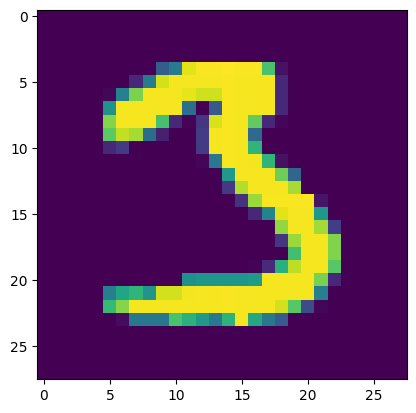

In [57]:
imagem, rotulo = MNIST_treino[11111]

imshow(imagem[0])
print(rotulo)

# Hiperparâmetros

In [ ]:
args = {
    'batch_size':       10,    #quantidade de amostras por iteração
    'num_threads':      2,    #número de threads do DataLoader
    #número real de batches = 20 (tamanho de cada batch * quantidade de threads)
    'num_classes':      len(MNIST_teste.classes),
    'taxa_aprendizado': 1e-4, # Encontrado euristicamente, hiperparâmetro
    'weight_decay':     5e-4, # Encontrado euristicamente, hiperparâmetro
    'num_epochs':       30,    # Encontrado euristicamente, hiperparâmetro
    'folds':            5     # Quantidade de folds da validação cruzada
}
neurons = {
    'input_size':   1 * 28 * 28, #dimensão de entrada (imagens de 28x28 bits com 1 canal de cor. precisa ser achatado para uma única dimensão)
    'hidden_size':  128, # dimensão escondida, hiperparâmetro
    'out_size':     args['num_classes']
}

# Definindo funções da rede

In [59]:
class MNIST_MLP(nn.Module):
  #Definição da nossa própria multi-layered perceptron
  def __init__(self, input_size, hidden_size, out_size):
    super(MNIST_MLP, self).__init__()

    #Definição das camadas e das funções de ativação intermediárias
    # aqui escolhemos duas redes lineares e como funções de ativação, ReLU duas vezes
    self.features  = nn.Sequential(
                        nn.Linear(input_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU())
    #A de saída também será linear
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()
    #Como estamos lidando com um processo de classificação, passaremos por um softmax

  def forward(self, input):
    #Define a computação de cada chamada
    input = input.view(input.size(0), -1) #Linearizando a entrada

    feature = self.features(input)
    output  = self.softmax(self.out(feature))

    return output


In [87]:
def treina(train_set, rede, epoca):
  rede.train() #modo treino

  start = time()

  epoch_loss = []
  all_labels = []
  all_preds = []

  for batch in train_set:
    dado, rotulo = batch

    dado = dado.to('cuda')
    rotulo = rotulo.to('cuda')

    # Forward
    pred = rede(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().item())

    pred_labels = torch.argmax(pred, dim=1).cpu().numpy()
    true_labels = rotulo.cpu().numpy()

    all_labels.extend(true_labels)
    all_preds.extend(pred_labels)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  end = time()

  f1 = f1_score(all_labels, all_preds, average='micro')

  print('\n')
  print("**********TREINA***********************")
  print("Época %d, Loss: %.4f +\- %.4f, F1 Score: %.4f, Tempo: %.2f" % (epoca, epoch_loss.mean(), epoch_loss.std(), f1, end-start))

  return epoch_loss.mean()


In [ ]:
def valida(teste_set, rede, epoca):
  rede.eval() #modo avaliação

  start = time()

  epoch_loss = []
  all_labels = []
  all_preds = []

  with no_grad():

    for batch in teste_set:

      dado, rotulo = batch

      dado = dado.to('cuda')
      rotulo = rotulo.to('cuda')

      # Forward
      pred = rede(dado)
      loss = criterion(pred, rotulo)
      epoch_loss.append(loss.cpu().item())

      pred_labels = torch.argmax(pred, dim=1).cpu().numpy()
      true_labels = rotulo.cpu().numpy()

      all_labels.extend(true_labels)
      all_preds.extend(pred_labels)

  epoch_loss = np.asarray(epoch_loss)

  f1 = f1_score(all_labels, all_preds, average='micro')

  end = time()

  print("**********VALIDA********************")
  print("Época %d, Loss: %.4f +\- %.4f, F1 Score: %.4f, Tempo: %.2f" % (epoca, epoch_loss.mean(), epoch_loss.std(), f1, end-start))

  return epoch_loss.mean()

In [93]:
def executa(treino, teste, rede, epocas):
  treino_loss, teste_loss = [], []
  for epoca in range(epocas):
    # Train
    treino_loss.append(treina(treino, rede, epoca))

    # Validate
    teste_loss.append(valida(teste, rede, epoca))

  return treino_loss, teste_loss

# Criando a rede

In [64]:
rede = MNIST_MLP(neurons['input_size'], neurons['hidden_size'], neurons['out_size']).to('cuda')
print(rede)

MNIST_MLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


In [65]:
criterion = nn.CrossEntropyLoss().to('cuda') #CrossEntropy indicado para classificação multiclasses

In [66]:
optimizer = optim.Adam(rede.parameters(), lr=args['taxa_aprendizado'], weight_decay=args['weight_decay'])
#Pesquisar sobre pq Adam (sei leigamente que é mt bom)

# Execução

In [67]:
kfold = StratifiedKFold(n_splits=args['folds'], shuffle=True, random_state=42)

In [68]:
MNIST[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [74]:
MNIST[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [94]:
for fold, (index_treino, index_teste) in enumerate(kfold.split(MNIST, target)):
  print(f"Fold {fold + 1} de {args['folds']}")

  treino_loader = DataLoader(MNIST_treino,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_threads'])

  teste_loader = DataLoader(MNIST_teste,
                            batch_size = args['batch_size'],
                            shuffle = True,
                            num_workers = args['num_threads'])

  executa(treino_loader, teste_loader, rede, args['num_epochs'])

Fold 1 de 5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 0, Loss: 2.3637 +\- 0.1339, F1 Score: 0.0974, Tempo: 47.45


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 0, Loss: 2.3629 +\- 0.1328, F1 Score: 0.0983, Tempo: 5.21


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 1, Loss: 2.3638 +\- 0.1318, F1 Score: 0.0974, Tempo: 46.05


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 1, Loss: 2.3630 +\- 0.1305, F1 Score: 0.0982, Tempo: 6.03


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 2, Loss: 2.3638 +\- 0.1324, F1 Score: 0.0974, Tempo: 46.12


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 2, Loss: 2.3630 +\- 0.1334, F1 Score: 0.0982, Tempo: 4.93


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 3, Loss: 2.3638 +\- 0.1333, F1 Score: 0.0974, Tempo: 46.79


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 3, Loss: 2.3630 +\- 0.1336, F1 Score: 0.0982, Tempo: 4.94


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 4, Loss: 2.3638 +\- 0.1331, F1 Score: 0.0974, Tempo: 46.33


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 4, Loss: 2.3630 +\- 0.1325, F1 Score: 0.0982, Tempo: 6.21


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 5, Loss: 2.3638 +\- 0.1327, F1 Score: 0.0974, Tempo: 46.17


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 5, Loss: 2.3630 +\- 0.1330, F1 Score: 0.0982, Tempo: 5.31


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 6, Loss: 2.3638 +\- 0.1335, F1 Score: 0.0974, Tempo: 50.21


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 6, Loss: 2.3630 +\- 0.1353, F1 Score: 0.0982, Tempo: 4.99


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)




**********TREINA***********************
Época 7, Loss: 2.3638 +\- 0.1334, F1 Score: 0.0974, Tempo: 47.46


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**********VALIDA********************
Época 7, Loss: 2.3630 +\- 0.1349, F1 Score: 0.0982, Tempo: 5.12


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


KeyboardInterrupt: ignored